# Neural Network 

In this notebook we are going to design a neural network algortihm for predicting housing prices. 

In [45]:
import numpy as np
import pandas as pd

# importing data
train_data = pd.read_csv('train.csv')

# Check missing values

If certain features in the data have a lot of missing values it is best to remove these columns out of our data set. 

In [35]:
def show_missing_info(df):
    
    '''This function detects missing values in a dataframe and returns a dataframe of features with missing
    values and the number of rows with and percentage of missing values within that feature in descending order.'''
    
    # Check all the NaN values in the dataframe and sum together
    missing_info = df.isna().sum().reset_index(drop=False)
    
    # create new dataframe with column names
    missing_info.columns = ["column","rows"]
    
    # add a column to the dataframe with the percentage of missing values
    missing_info["percentage missing"] = (missing_info["rows"]/train_data.shape[0])*100
    
    # sort the dataframe descending 
    missing_info = missing_info[missing_info["rows"]>0].sort_values(by="percentage missing",ascending=False)
    
    return missing_info


# Show information about features with missing values in the train data
missing_df = show_missing_info(train_data)
print(f'Features with missing values: \n')
print(missing_df)

# Make a list of the top 5 features with the most missing values in the train data
all_missing = list(missing_df['column'])
top5 = list(missing_df['column'].head(5))

Features with missing values: 

          column  rows  percentage missing
72        PoolQC  1453           99.520548
74   MiscFeature  1406           96.301370
6          Alley  1369           93.767123
73         Fence  1179           80.753425
57   FireplaceQu   690           47.260274
3    LotFrontage   259           17.739726
58    GarageType    81            5.547945
59   GarageYrBlt    81            5.547945
60  GarageFinish    81            5.547945
63    GarageQual    81            5.547945
64    GarageCond    81            5.547945
32  BsmtExposure    38            2.602740
35  BsmtFinType2    38            2.602740
33  BsmtFinType1    37            2.534247
31      BsmtCond    37            2.534247
30      BsmtQual    37            2.534247
26    MasVnrArea     8            0.547945
25    MasVnrType     8            0.547945
42    Electrical     1            0.068493


#### Replace missing values
Other missing values in other columns are replaced by the mean of that feature (numerical data) or by the category which is most abundant (categorical data). 

In [36]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def cleaning(df, top5):
    
    '''This function corrects any missing values in a pandas dataframe and
    returns the cleaned dataframe.'''
    
    # Loop through all the features/columns in the training data
    for column in df:
        
        # if column is in top 5 of columns with most missing data, drop column
        if column in top5:
            df = df.drop(column, 1)
        
        # check whether the data in each column is numerical
        elif is_numeric_dtype(df[column]):

            # if the data is numerical compute the mean of the whole column values
            column_mean = df[column].mean()

            # replace the missing values in this column with the mean of the column
            df[column] = df[column].fillna(column_mean)

        # replace categorical missing values with the most common categorical value
        else:
            df[column] = df[column].fillna(df[column].value_counts().index[0])
    
    return df

# clean the imported training data 
train_data_cleaned = cleaning(train_data, top5)

C:\Users\gwyne\anaconda3\envs\progLab\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


#### One hot encode categorical data
In order for a neural network to handle categorical data, the data is one hot encoded in the cell below. 

In [37]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df):
    
    '''One hot encode categorical data from a dataframe.'''
        
    # Select all categorical features and numberical features
    cat_data = df.select_dtypes(include=[object])
    num_data = df.select_dtypes(exclude=[object])
    
    # Create a LabelEncoder object and apply it to each categorical feature in the data
    le = preprocessing.LabelEncoder()
    cat_data_2 = cat_data.apply(le.fit_transform)
    
    # Create an OneHotEncoder object and fit it to all categorical data
    enc = preprocessing.OneHotEncoder()
    enc.fit(cat_data_2)
    onehotlabels = enc.transform(cat_data_2).toarray()
    
    # Get all possible categories from the data
    all_categories = enc.get_feature_names(cat_data_2.columns)

    # Create new dataframe with all possible categories as columns
    cat_data = pd.DataFrame(onehotlabels, columns = all_categories)
    
    # Merge the numerical data with the one hot encoded categorical data again
    result = pd.concat([cat_data, num_data], axis=1).reindex(num_data.index)
        
    return result

# one hot encode the train data
train_data_oh = one_hot_encoding(train_data_cleaned)

#### Divide the data in X and y subsets and in train and test data. 

In [38]:
from sklearn.model_selection import train_test_split

# select the Sale price from the training data = y 
y_train = train_data_oh['SalePrice']
X_train = train_data_oh.iloc[:, :-1]

# divide the data into train and test data
train_X, test_X, train_y, test_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Normalize the data

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

# Benchmark Neural Network

In the code below, a basic neural network is made as a benchmark for further adjustments. 
We started with a simple neural network with 2 hidden layer and 20 epochs and implemented all 271 features.

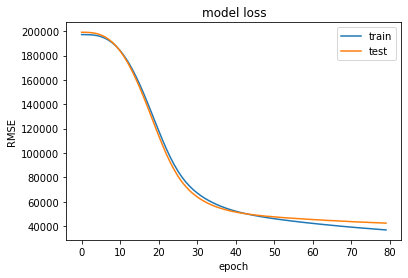

MAE: 30812.215315309288
RMSE: 42413.523631285796
RMSE_log: 0.474595110612408


In [40]:
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import math
from math import sqrt


# neural network architecture
model = Sequential()
model.add(Dense(120, input_dim=271, activation= 'relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# training the neural network
model.compile(loss='mean_squared_error', optimizer= 'adam')
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 80, verbose=0)


# plot the training loss and the testing loss
# model takes mean squared error, take root of mse
for i in range(len(history.history['loss'])):
    history.history['loss'][i] = np.sqrt(history.history['loss'][i])
    history.history['val_loss'][i] = np.sqrt(history.history['val_loss'][i])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# calculating the error of our model
# with the MAE
predictions = model.predict(test_X)
MAE = mean_absolute_error(test_y, predictions)
print("MAE:", MAE)

# The RMSE
RMSE = sqrt(mean_squared_error(test_y, predictions))
print("RMSE:", RMSE)

# and the RMSE with both y values in the logarithm
RMSE_log = sqrt(mean_absolute_error(np.log(test_y), np.log(predictions)))
print("RMSE_log:", RMSE_log)

This very simple model (epoch = 20) resulted in an RMSE of 112,774.
Increasing epochs to 80 resulted in a RMSE of 41,683. 
Our model shows relatively high bias and therefore, the next step was to make out model more complex with and extra hidden layer. 

# Neural Network 2

In the network below, more layers are implemented.

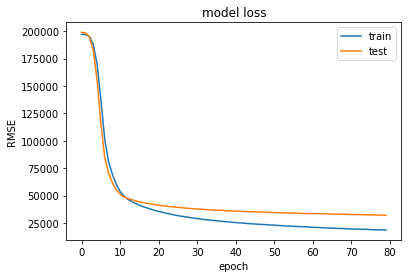

MAE: 22260.110324807363
RMSE: 32012.683126798096
RMSE_log: 0.3712647659420237


In [41]:
# neural network architecture
model = Sequential()
model.add(Dense(200, input_dim=271, activation= 'relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# training the neural network
model.compile(loss='mean_squared_error', optimizer= 'adam')
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 80, verbose=0)


# plot the training loss and the testing loss
# model takes mean squared error, take root of mse
for i in range(len(history.history['loss'])):
    history.history['loss'][i] = np.sqrt(history.history['loss'][i])
    history.history['val_loss'][i] = np.sqrt(history.history['val_loss'][i])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# calculating the error of our model
# with the MAE
predictions = model.predict(test_X)
MAE = mean_absolute_error(test_y, predictions)
print("MAE:", MAE)

# The RMSE
RMSE = sqrt(mean_squared_error(test_y, predictions))
print("RMSE:", RMSE)

# and the RMSE with both y values in the logarithm
RMSE_log = sqrt(mean_absolute_error(np.log(test_y), np.log(predictions)))
print("RMSE_log:", RMSE_log)

Increasing the number of hidden layers resulted in an RMSE of 31,788. Our model seems a bit overfit now as the performance of the model on the test data is less compared to the train data. The next step is to reduce overfitting by implementing dropout layers

# Neural network 3
In the network below dropout is added to counter the overfitting in the model. 

We experimented with different dropout layers: 
- Dropout 10% 1x = 30,000 RMSE
- Dropout 10% 2x = 29,999 RMSE = BEST OPTION

- Dropout 30% 1x = 30,100 RMSE
- Dropout 30% 2x = 31,100 RMSE

- Dropout 50% 1x = 32,100 RMSE
- Dropout 50% 2x = 31,500 RMSE
 
Dropouts decreased the RMSE slightly but not significantly. 

Implementing stochastic gradient descent (SGD) with:
- Learning rate = 0.01
- Momentum = 0.9
- Clipnorm = 1

Resulted in RMSE of 26,658. 

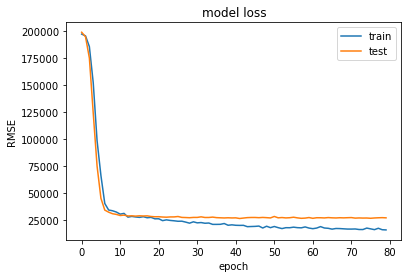

MAE: 16791.10592358733
RMSE: 27094.8128569157
RMSE_log: 0.3106575181045116


In [42]:
from tensorflow import keras
from keras.layers import Dropout


# neural network architecture
model = Sequential()
model.add(Dense(200, input_dim=271, activation= 'relu'))
model.add(Dropout(0.1))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(75, activation='relu'))
model.add(Dense(1))

# training the neural network
optimizer = keras.optimizers.SGD(learning_rate=0.01, name='SGD', momentum = 0.9, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer= optimizer)


history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 80, verbose=0)


# plot the training loss and the testing loss
# model takes mean squared error, take root of mse
for i in range(len(history.history['loss'])):
    history.history['loss'][i] = np.sqrt(history.history['loss'][i])
    history.history['val_loss'][i] = np.sqrt(history.history['val_loss'][i])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# calculating the error of our model
# with the MAE
predictions = model.predict(test_X)
MAE = mean_absolute_error(test_y, predictions)
print("MAE:", MAE)

# The RMSE
RMSE = sqrt(mean_squared_error(test_y, predictions))
print("RMSE:", RMSE)

# and the RMSE with both y values in the logarithm
RMSE_log = sqrt(mean_absolute_error(np.log(test_y), np.log(predictions)))
print("RMSE_log:", RMSE_log)

Our model seems to be overfitting after 20 epochs. We tried to implement another activtion function which is LeakyReLU

### Model 4

In the code below we implemented LeakyReLU as the activation function as this function can prevent dead nodes in our neural network. This resulted in an RMSE of 26,557.

Furthermore, we experimented with the learning rate and the momentum to increase model performance: 
- lr=0.1, momentum=0.1 --> RMSE=26,777
- lr=0.01, momentum=0.1 --> RMSE=31,743
- lr=0.01, momentum=0.2 --> RMSE=31,223
- lr=0.1, momentum=0.2 --> RMSE=26,351
- lr=0.1, momentum=0.3 --> RMSE=27,139

Next we tried changing the dropout layers as our model seemed overfit:
- lr=0.1, momentum=0.3, dropout=0.3 -->  RMSE=27,116

And added another layer:
- lr=0.1, momentum=0.3, dropout=0.3, 1e hidden layer = 300 --> RMSE=26,759

We experimented more with the learning rate and the amount of epochs:
- lr=0.005, momentum=0.3, dropout=0.3 --> RMSE=43,786
- lr=0.005, momentum=0.3, dropout=0.3, epochs=200 --> RMSE=28,700
- lr=0.005, momentum=0.3, dropout=0.3, epochs=300 --> RMSE=27,900

The model was in this case a bit underfit so we added 2 extra hidden layers:
- lr=0.005, momentum=0.3, dropout=0.3, epochs=300 --> RMSE=27,900

The mode became underfit so we changed the dropout layers:
- lr=0.005, momentum=0.3, dropout=0.2, epochs=300 --> RMSE=28,219
- lr=0.005, momentum=0.3, dropout=0.1, epochs=300 --> RMSE=27,476
- lr=0.01, momentum=0.3, dropout=0.1, epochs=300 --> RMSE=27,093

Finally we experimented some more with dropout layers, learning rate and the amount of epochs:
- lr=0.01, momentum=0.3, dropout=0.1, epochs=300, --> RMSE=27,260
- lr=0.005, momentum=0.4, dropout=0.1, epochs=300, --> RMSE=26,811
- lr=0.005, momentum=0.4, dropout=0.1, epochs=100, --> RMSE=28,000
- lr=0.005, momentum=0.4, dropout=0.1, epochs=150, --> RMSE=28,229
- lr=0.005, momentum=0.4, dropout=0.1, epochs=200, --> RMSE=26,992 
- lr=0.005, momentum=0.8, dropout=0.1, epochs=200, --> RMSE=26,992 

The final model is written in the cell below:

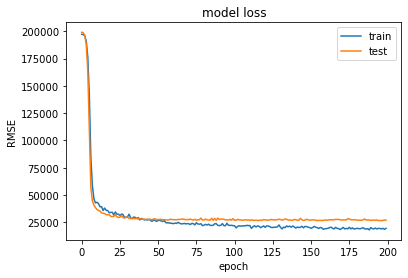

In [43]:
from keras.layers import LeakyReLU


# neural network architecture
model = Sequential()
model.add(Dense(271, input_dim=271))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(300))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(150))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(75))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(30))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1))

# training the neural network
optimizer = keras.optimizers.SGD(learning_rate=0.005, name='SGD', momentum = 0.8, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer= optimizer)


history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 200, verbose=0)


# plot the training loss and the testing loss
# model takes mean squared error, take root of mse
for i in range(len(history.history['loss'])):
    history.history['loss'][i] = np.sqrt(history.history['loss'][i])
    history.history['val_loss'][i] = np.sqrt(history.history['val_loss'][i])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [44]:
# calculating the error of our model
# with the MAE
predictions = model.predict(test_X)
MAE = mean_absolute_error(test_y, predictions)
print("MAE:", MAE)

# The RMSE
RMSE = sqrt(mean_squared_error(test_y, predictions))
print("RMSE:", RMSE)

# and the RMSE with both y values in the logarithm
RMSE_log = sqrt(mean_absolute_error(np.log(test_y), np.log(predictions)))
print("RMSE_log:", RMSE_log)


MAE: 17086.04476134418
RMSE: 26941.80197638695
RMSE_log: 0.31248010952882715


We also tried to implement another loss function instead of the Mean Squared Error (MSE) as the MSE can give a relatively high weight to large errors. That is why we implemented the mean absolute error (MAE) in the code below. 

# Different loss function

implementing the Mean Absolute Error (MAE). 

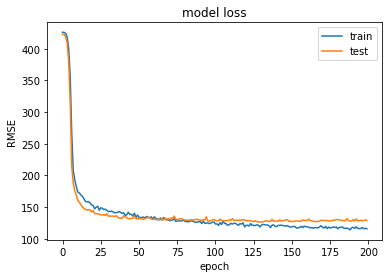

MAE: 16656.70079730308
RMSE: 26443.552474141343
RMSE_log: 0.30997760099814564


In [29]:
# neural network architecture
model = Sequential()
model.add(Dense(300, input_dim=271))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(200))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(150))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(75))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(30))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1))

# training the neural network
optimizer = keras.optimizers.SGD(learning_rate=0.005, name='SGD', momentum = 0.8, clipnorm=1)
model.compile(loss='mean_absolute_error', optimizer= optimizer)


history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 200, verbose=0)


# plot the training loss and the testing loss
# model takes mean squared error, take root of mse
for i in range(len(history.history['loss'])):
    history.history['loss'][i] = np.sqrt(history.history['loss'][i])
    history.history['val_loss'][i] = np.sqrt(history.history['val_loss'][i])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# calculating the error of our model
# with the MAE
predictions = model.predict(test_X)
MAE = mean_absolute_error(test_y, predictions)
print("MAE:", MAE)

# The RMSE
RMSE = sqrt(mean_squared_error(test_y, predictions))
print("RMSE:", RMSE)

# and the RMSE with both y values in the logarithm
RMSE_log = sqrt(mean_absolute_error(np.log(test_y), np.log(predictions)))
print("RMSE_log:", RMSE_log)

We decided to not try to improve the model above by changing the parameters. Instead we aimed to try changing the input data by choosing a different amount of feaures. Till so far, we implemented all 271 features while it is possible not all those features contribute to the accuracy of our model. 

### Best features

We started with the best 20 features, which means these features have the top 20 highest correlation with the sales prices.

In the cell below a subset of the data is created with only 20 features. 

In [13]:
def select_correlated_features(X_train, y_train, no_features):
    
    '''This function selects x features (=no_features) from X_train which are most correlated
    with the SalePrice (y_train) and returns this subset of X_train.'''
    
    # Determine correlations of features with the sale price in descending order
    correlations = X_train.corrwith(y_train).sort_values(ascending=False)
    
    # Create lists of features with the x highest correlations with the SalePrice
    top_cor = list(correlations.head(no_features).index.values)

    # Only remain features in df which are in that list
    X_train_subset = X_train[X_train.columns.intersection(top_cor)]
    
    return X_train_subset

# create subset of the data with 20 best features
X_train_subset = select_correlated_features(X_train, y_train, 20)

# split the data in test and train
train_X, test_X, train_y, test_y = train_test_split(X_train_subset, y_train, test_size=0.3, random_state=42)

# normalize the data
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)


#### Neural network architecture

We started again with a simple neural net and adjusted the epochs and learningrate a bit: 
- Adam optimizer, ReLU, lr=0.1, 2 hidden layer, epochs=200 --> RMSE=33478
- Adam optimizer, ReLU, lr=0.01, 2 hidden layer, epochs=200 --> RMSE=32,826
- Adam optimizer, ReLU, lr=0.01, 2 hidden layer, epochs=300 --> RMSE=31,537

The model seemed slightly underfit so we added another hidden layer:
- Adam optimizer, ReLU, lr=0.01, 3 hidden layer, epochs=200 --> RMSE=32,586

Then we implemented Leaky ReLU as activation function
- Adam optimizer, LeakyReLU, lr=0.01, 2 hidden layer, epochs=200 --> RMSE=31,117

We added another hidden layer as the model was stil underfit:
- Adam optimizer, LeakyReLU, lr=0.01, 4 hidden layer, epochs=200 --> RMSE=34,571

We decided a hidden layer less worked so we deleted 1 hidden layer and deleted 1 dropout layer 10%:
- Adam optimizer, LeakyReLU, lr=0.01, 3 hidden layer, epochs=200 --> RMSE=32,631

The we changed the optimizer in SGD:
- SDG. lr=0.01, LeakyReLU, 4 hidden layers, epochs=200 --> RMSE=27,606
- SDG, lr=0.01, LeakyReLU, 4 hidden layers, epochs=200, momentum=0.1 --> RMSE=27,718

Overall the best model with 20 features resulted in:
- SGD, lr=0.01, 5 hidden layers, epochs=200, momentum=0.1, clipnorm=0.9 --> RMSE=27,681

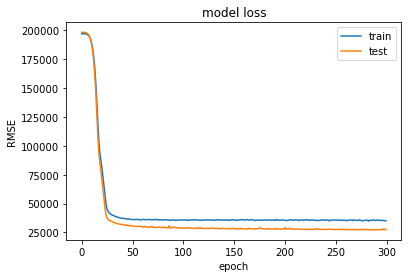

MAE: 18667.309610445205
RMSE: 27591.015187435758
RMSE_log: 0.32811880146336464


In [15]:
# neural network architecture
model = Sequential()
model.add(Dense(20, input_dim=20))
model.add(LeakyReLU(alpha=0.1))

# model.add(Dropout(0.1))
model.add(Dense(40))
model.add(LeakyReLU(alpha=0.1))

# model.add(Dropout(0.3))
model.add(Dense(30))
model.add(LeakyReLU(alpha=0.1))

# model.add(Dropout(0.3))
model.add(Dense(15))
model.add(LeakyReLU(alpha=0.1))

# model.add(Dropout(0.3))
model.add(Dense(5))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1))

# training the neural network
optimizer = keras.optimizers.SGD(learning_rate=0.01, name='SGD', momentum = 0.1, clipnorm=0.9)
# optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer= optimizer)

history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 300, verbose=0)

# plot the training loss and the testing loss
# model takes mean squared error, take root of mse
for i in range(len(history.history['loss'])):
    history.history['loss'][i] = np.sqrt(history.history['loss'][i])
    history.history['val_loss'][i] = np.sqrt(history.history['val_loss'][i])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# calculating the error of our model
# with the MAE
predictions = model.predict(test_X)
MAE = mean_absolute_error(test_y, predictions)
print("MAE:", MAE)

# The RMSE
RMSE = sqrt(mean_squared_error(test_y, predictions))
print("RMSE:", RMSE)

# and the RMSE with both y values in the logarithm
RMSE_log = sqrt(mean_absolute_error(np.log(test_y), np.log(predictions)))
print("RMSE_log:", RMSE_log)

Choosing 20 features did not do out model justice, however, 20 was simply a guess. In the code below we wrote a code to choose the best amount of features for our model. 

## Choose the best amount of features 

The code below is intended to choose the best amount of features in our neural network. the RMSE will be calculated for every model with a different number of features. The code is however to computational expensive for running it here. Therefore, the code is running in the Google Colab GPU. 

We started with a neural network with 3 hidden layers, Adam optimizer and 100 epochs. 

In [16]:
# create empty lists to store the number of features and the average RMSE values 
n_features = []
rmse_list = []

# loop through ever number of features
for i in range(1, 272):
    
    # save the number of the features in the empty list
    n_features.append(i)
    
    # create a subset of the training data with that number of features
    X_subset = select_correlated_features(X_train, y_train, i)
    
    avg_rmse = 0
    
    # let the model run the 10 times with the same amount of features and save the average RMSE
    for j in range(1, 11):
    
        # split the data in test and train set
        train_X, test_X, train_y, test_y = train_test_split(X_subset, y_train, test_size=0.3, random_state=42)
        
        # normalize the data
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        # model architecture: start relatively simple
        model = Sequential()
        model.add(Dense(i, input_dim=i))
        model.add(LeakyReLU(alpha=0.1))

        model.add(Dropout(0.1))
        model.add(Dense(50))
        model.add(LeakyReLU(alpha=0.1))

        model.add(Dropout(0.1))
        model.add(Dense(30))
        model.add(LeakyReLU(alpha=0.1))

        model.add(Dense(1))

        # training the neural network
        model.compile(loss='mean_squared_error', optimizer = 'adam')
        model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 100, verbose=0)

        # calculate the predictions and the RMSE:
        predictions = model.predict(test_X)
        RMSE = sqrt(mean_squared_error(test_y, predictions))
        avg_rmse += RMSE
    
    # save the average RMSE to a list 
    avg_rmse = avg_rmse/10
    rmse_list.append(avg_rmse)



KeyboardInterrupt: 

The code written in the cell above was eventually to heavy to run for all the features also in the Google Colab. Therefore, this code was run separately in four runs and saved in an excel file manually. The list with all the number of features was also written by a for loop in the cell below. 

In [ ]:
# create the list of features 
n_features = []
for i in range(1, 272):
    n_features.append(i)

# import the RMSE csv file list manually put together 
rmse_list = pd.read_csv("RMSElist.csv")

# find the lowest RMSE value
min_rmse = rmse_list.min()

# find the corresponding number of feature
number_features = np.where(rmse_list==min_rmse)
number_features = int("".join(map(str, number_features[0])))
print(f"The number of features which resulted in the lowest RMSE is: {number_features}.")

# plot all the RMSE values versus the number of features for visualization of the process
plt.plot(n_features, rmse_list, color="green")
plt.plot(number_features, min_rmse, "o", color="red")
plt.xlabel("Number of features")
plt.ylabel("Average RMSE")
plt.title("Average RMSE value per number of features")
plt.xlim(1, 271)
plt.show()



### Best amount of features implemented in our best neural network

As seen in the cells above, our model seems to perform best on the 92 best features of the data set. Before we selected our features we had already created a model with the lowest RMSE till so far, so we decided to run this model again but then with only 92 features instead of 271. 

In [31]:
def select_correlated_features(X_train, y_train, no_features):
    
    '''This function selects x features (=no_features) from X_train which are most correlated
    with the SalePrice (y_train) and returns this subset of X_train.'''
    
    # Determine correlations of features with the sale price in descending order
    correlations = X_train.corrwith(y_train).sort_values(ascending=False)
    
    # Create lists of features with the x highest correlations with the SalePrice
    top_cor = list(correlations.head(no_features).index.values)

    # Only remain features in df which are in that list
    X_train_subset = X_train[X_train.columns.intersection(top_cor)]
    
    return X_train_subset

# create the subset dataframe with 92 features
X_train_subset = select_correlated_features(X_train, y_train, 92)

# prepare the data
train_X, test_X, train_y, test_y = train_test_split(X_train_subset, y_train, test_size=0.3, random_state=42)

# normalize the data
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

The best model with 92 features gave a RMSE of 25,540. We decided to tweak the parameters slightly. The final model is written in the cell below and the process to get there is listed at the end of the notebook.

Model: "sequential_426"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1706 (Dense)           (None, 200)               18600     
_________________________________________________________________
leaky_re_lu_1259 (LeakyReLU) (None, 200)               0         
_________________________________________________________________
dropout_842 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_1707 (Dense)           (None, 150)               30150     
_________________________________________________________________
leaky_re_lu_1260 (LeakyReLU) (None, 150)               0         
_________________________________________________________________
dropout_843 (Dropout)        (None, 150)               0         
_________________________________________________________________
dense_1708 (Dense)           (None, 100)            

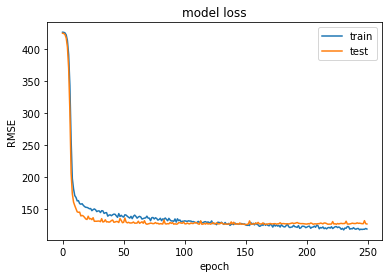

MAE: 16190.55512450057
RMSE: 25091.210889918493
RMSE_log: 0.30320171478112784


In [33]:
# neural network architecture
model = Sequential()
model.add(Dense(200, input_dim=92))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.2))
model.add(Dense(150))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(100))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.1))
model.add(Dense(75))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(30))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1))
model.summary()

# training the neural network
optimizer = keras.optimizers.SGD(learning_rate=0.005, name='SGD', momentum = 0.8, clipnorm=1)
model.compile(loss='mean_absolute_error', optimizer= optimizer)

history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 250, verbose=0)

# plot the training loss and the testing loss
# model takes mean squared error, take root of mse
for i in range(len(history.history['loss'])):
    history.history['loss'][i] = np.sqrt(history.history['loss'][i])
    history.history['val_loss'][i] = np.sqrt(history.history['val_loss'][i])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# calculating the error of our model
# with the MAE
predictions = model.predict(test_X)
MAE = mean_absolute_error(test_y, predictions)
print("MAE:", MAE)

# The RMSE
RMSE = sqrt(mean_squared_error(test_y, predictions))
print("RMSE:", RMSE)

# and the RMSE with both y values in the logarithm
RMSE_log = sqrt(mean_absolute_error(np.log(test_y), np.log(predictions)))
print("RMSE_log:", RMSE_log)

Tweak parameters:

1. We changed the amount of nodes between the hidden layers to get a more diamond shaped neural network: 
Layers: 92 input --> 150 --> 100 --> 75 --> 30 --> 1 output, which gave a RMSE of 24,800

2. The model seemed after this change quite underfit so we trained the model for 250 epochs instead of 200 and removed the dropout layers. This resulted in an RMSE of 25,678 and a very overfit model. 

3. We increased the dropout layers again by 1 dropout of 10% after the first layers which resulted in an RMSE of 24,928. The model was still overfit.

4. We added another dropout layer after the first hidden layer of 10% which resulted in an RMSE of 24,678 and the model was still slightly overfit. 

5. We changed the first dropout layer to 20% which resulted in a RMSE of 24,562, the model was still slightly overfit. 

6. We added another dropout layer after the second hidden layer of 10% which resulted in an RMSE of 24,484. 

We decided to leave the model at this stage 